# Chapter 7
## Detection Using Neural Networks

In [1]:
import os, sys
import numpy as np
from math import floor
import pickle
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from tqdm import tqdm
import h5py
from scipy import signal
import multiprocessing as mp


from sklearn import model_selection,preprocessing
# os.environ['THEANO_FLAGS'] = "device=cuda,force_device=True,floatX=float32"
# os.environ["KERAS_BACKEND"] = "theano"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l1,l2, l1_l2
from tensorflow.keras.models import load_model
from keras.utils import plot_model, np_utils



# import python library
sys.path.append(os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'py'))
from sample import Sample
from dataset import Dataset
from database import Database
from yolo_data_aug import YOLODataAug
from yolo_detector import YOLODetector

dataset_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'awdEvents1')
database_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','databases', 'awdEvents1')
dataset_sim_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','datasets', 'simulations', 'simple' ,'whistler')
result_loc = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'data','results', 'awdEvents1')
site = 'marion'
database = Database(dataset_loc, database_loc, site)
# dataset_sim = DatasetSimulation(dataset_sim_loc, 0.006395061728395062, 0.15503875968992248)
# yolo_aug = YOLODataAug(dataset_loc, database_loc, site)

linewidth = 2
font_title = 32
font_legend = 20
font_label = 24
font_ticks = 18
font = [font_title, font_legend, font_label, font_ticks, linewidth] # [None]*5

# use gpu
# print('GPUs:',K.tensorflow_backend._get_available_gpus())
# gpu_options = tf.GPUOptions(allow_growth=True)
# session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


##  **6.2 Classifier Design**

### Dataset

**Generate Dataset**

In [2]:
transforms, transforms_params = ['slice', 'scale'], [[1.5,9.5],[0,1]]
cut_params = [1,0.2,8,1.5,1]
# database.create_cuts_db_mp(transforms, transforms_params,cut_params, verbose=True, noise=True, train=True, test=True)

**Show dataset statistics**

In [5]:
_ = database.stats(transforms, transforms_params,cut_params, noise=True, test=False)

/srv/home/knnoth001/wdml/data/databases/awdEvents1/marion/marion_h5/['slice', 'scale']_[[1.5, 9.5], [0, 1]]_[1, 0.2, 8, 1.5, 1]_True/train
samples:  7968


100%|██████████| 7968/7968 [00:04<00:00, 1849.73it/s]



Database statistics               
min                   0           
max                   1           
mean                  0.586       
std                   0.113       
noise                 2850[35.77%]
whistler              5118[64.23%]
total                 7968        



**Load dataset**

In [3]:
X , Y = database.load_cuts_db_mp(transforms, transforms_params,cut_params, noise=True, verbose=True, test=False, shuffle=True, random_state=42)

/srv/home/knnoth001/wdml/data/databases/awdEvents1/marion/marion_h5/['slice', 'scale']_[[1.5, 9.5], [0, 1]]_[1, 0.2, 8, 1.5, 1]_True/train
samples:  7968


100%|██████████| 7968/7968 [00:04<00:00, 1987.22it/s]


**Show few examples**

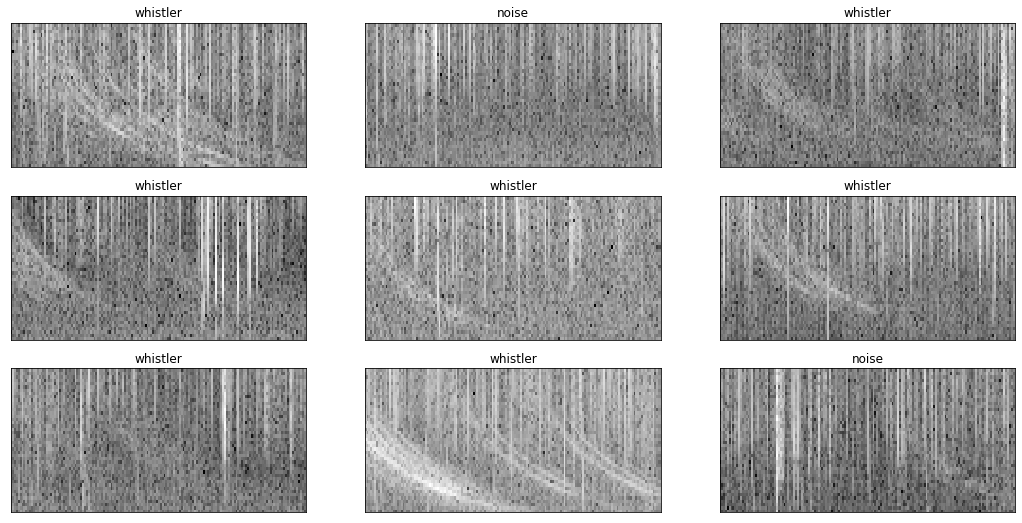

In [4]:
x_size = 3
y_size = 3
scale = 3
plt.figure(figsize=(y_size*2*scale, x_size*scale))
for ix in range(x_size*y_size):
    ax = plt.subplot(x_size, y_size, ix+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    index = np.random.randint(len(Y))
    plt.pcolormesh(X[index], cmap='gray')
    ax.set_title('whistler' if Y[index]==1 else 'noise')
plt.show()

**Reshape data and label and rescale it**

In [5]:
freq_len, time_len = X[0].shape
data = X.reshape(len(X),freq_len*time_len)
scaler = preprocessing.StandardScaler().fit(data)
data = scaler.transform(data)
data = data.reshape((len(data),1,freq_len,time_len))
evt = np_utils.to_categorical(Y)
print(X.shape, Y.shape)
print(data.shape,evt.shape)
print(Y)

# save scaler
print('Saving scaler ....')
standard_scaler = {"scaler": scaler}
scaler_path = os.path.join(database_loc,site,'models',str(transforms)+'_'+str(transforms_params)+'_scaler.pickle')
pickle.dump( standard_scaler, open(scaler_path, "wb" ) )
print('Done')

(7968, 44, 156) (7968,)
(7968, 1, 44, 156) (7968, 2)
[ True  True False ...  True  True  True]
Saving scaler ....
Done


**Define Model**

In [11]:
model = Sequential()
model.add(Conv2D(16,(7,7), input_shape=(1,freq_len, time_len),
                    padding='same', activation='relu',data_format='channels_first'))
model.add(Dropout(0.6))
model.add(Conv2D(16, (11,11), activation='relu', padding='same',data_format='channels_first'))
model.add(Dropout(0.7))
model.add(Conv2D(8, (21,21), activation='relu', padding='same',data_format='channels_first'))
model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
model.add(Conv2D(5, (21,21), activation='relu', padding='same',data_format='channels_first'))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

#compile model
epochs = 25
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 44, 156)       800       
_________________________________________________________________
dropout (Dropout)            (None, 16, 44, 156)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 44, 156)       30992     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 44, 156)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 44, 156)        56456     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 22, 78)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 78)        

**Train Model**

In [12]:
history = model.fit(data, evt, validation_split=0.3, epochs=epochs, batch_size=250, shuffle=True)
print(history.history.keys())

Train on 5577 samples, validate on 2391 samples
Epoch 1/25
5577/5577 [==============================] - 15s 3ms/sample - loss: 0.6601 - accuracy: 0.6324 - val_loss: 0.5223 - val_accuracy: 0.7792
Epoch 2/25
5577/5577 [==============================] - 6s 1ms/sample - loss: 0.3350 - accuracy: 0.8618 - val_loss: 0.2327 - val_accuracy: 0.9130
Epoch 3/25
5577/5577 [==============================] - 6s 1ms/sample - loss: 0.1846 - accuracy: 0.9295 - val_loss: 0.1811 - val_accuracy: 0.9385
Epoch 4/25
5577/5577 [==============================] - 6s 1ms/sample - loss: 0.1714 - accuracy: 0.9408 - val_loss: 0.1623 - val_accuracy: 0.9460
Epoch 5/25
5577/5577 [==============================] - 6s 1ms/sample - loss: 0.1402 - accuracy: 0.9514 - val_loss: 0.1320 - val_accuracy: 0.9557
Epoch 6/25
5577/5577 [==============================] - 6s 1ms/sample - loss: 0.1215 - accuracy: 0.9561 - val_loss: 0.1266 - val_accuracy: 0.9619
Epoch 7/25
5577/5577 [==============================] - 6s 1ms/sample - los

**Save Model and its History**

In [16]:
params = str(transforms)+'_'+str(transforms_params)
# save history
_history = {"history": history.history}
history_path = os.path.join(database_loc,site,'models',params+'_history.pickle')
pickle.dump( _history, open(history_path, "wb" ) )

# save model
model_path = os.path.join(database_loc,site,'models',params+'_model.h5')
model.save(model_path)

**Plot history**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


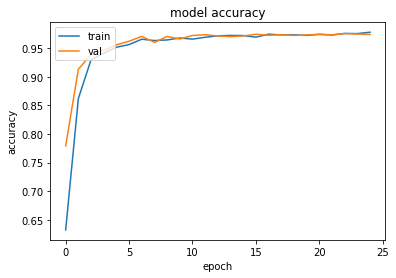

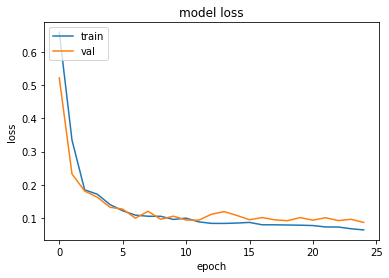

In [3]:
params = str(transforms)+'_'+str(transforms_params)
scaler_path = os.path.join(database_loc,site,'models',params+'_scaler.pickle')
history_path = os.path.join(database_loc,site,'models',params+'_history.pickle')
model_path = os.path.join(database_loc,site,'models',params+'_model.h5')

scaler = pickle.load( open( scaler_path, "rb" ) )['scaler']
history = pickle.load( open( history_path, "rb" ) )['history']
print(history.keys())

from neural_network import NeuralNetwork
nn = NeuralNetwork()

# summarize history for accuracy
nn.show_history(history)